In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [ ]:
# train -> train0+train1+train2
train_path="/content/gdrive/MyDrive/TRAIN_UP"
# test -> test0+test1+test2
test_path="/content/gdrive/MyDrive/TEST_UP"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/gdrive/My Drive/TRAIN_UP")
test_generator = test_datagen.flow_from_directory("/content/gdrive/My Drive/TEST_UP")

In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [ ]:
base_model.load_weights("/content/gdrive/My Drive/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [ ]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel= Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel= Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 3,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.summary()

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

In [ ]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [ ]:
mc = ModelCheckpoint('/content/gdrive/My Drive/resnet_model.h5', monitor='val_accuracy')

In [ ]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0001, nesterov=False)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

Training The Model


In [ ]:
H = model.fit_generator(train_generator,validation_data =test_generator, epochs=40,verbose=1,callbacks=[mc,es])

<ipython-input-19-cc9dd5dc3bcd>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(train_generator,validation_data =test_generator, epochs=40,verbose=1,callbacks=[mc,es])


Epoch 1/40
44/44 [==============================] - 633s 14s/step - loss: 0.7532 - accuracy: 0.6904 - val_loss: 0.5031 - val_accuracy: 0.7874
Epoch 2/40
44/44 [==============================] - 267s 6s/step - loss: 0.5148 - accuracy: 0.7931 - val_loss: 0.5078 - val_accuracy: 0.7824
Epoch 3/40
44/44 [==============================] - 263s 6s/step - loss: 0.4830 - accuracy: 0.8024 - val_loss: 0.5001 - val_accuracy: 0.7990
Epoch 4/40
44/44 [==============================] - 265s 6s/step - loss: 0.4555 - accuracy: 0.8089 - val_loss: 0.4503 - val_accuracy: 0.8007
Epoch 5/40
44/44 [==============================] - 268s 6s/step - loss: 0.3758 - accuracy: 0.8405 - val_loss: 0.5083 - val_accuracy: 0.8123
Epoch 6/40
44/44 [==============================] - 266s 6s/step - loss: 0.3561 - accuracy: 0.8527 - val_loss: 0.4800 - val_accuracy: 0.8023
Epoch 7/40
44/44 [==============================] - 267s 6s/step - loss: 0.3611 - accuracy: 0.8477 - val_loss: 0.4312 - val_accuracy: 0.8140
Epoch 8/40
4

In [ ]:
model.evaluate_generator(test_generator)

<ipython-input-20-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.40039849281311035, 0.8637873530387878]

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import model_from_json

In [ ]:
def predict_(image_path):
  #Load the Model from Json File
  json_file = open('/content/gdrive/My Drive/model.json', 'r')
  model_json_c = json_file.read()
  json_file.close()
  model_c = model_from_json(model_json_c)
  #Load the weights
  model_c.load_weights("/content/gdrive/My Drive/resenet_model.h5")
  #Compile the model
  opt = SGD(lr=1e-4, momentum=0.9)
  model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
  #load the image you want to classify
  image = cv2.imread(image_path)
  image = cv2.resize(image, (224,224))
  cv2_imshow(image)
  #predict the image
  preds = model_c.predict(np.expand_dims(image, axis=0))[0]
  prediction = max(preds)
  print(preds)

  if prediction==preds[0]:
      print("Predicted Label: 0")
  elif prediction==preds[1]:
      print("Predicted Label: 1")
  else:
      print("Predicted Label: 2")


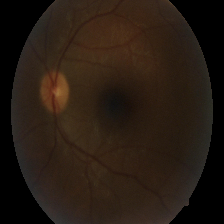

1/1 [==============================] - 2s 2s/step
[0.0000000e+00 4.4457323e-35 3.4170673e-30]
Predicted Label: 2


In [ ]:
predict_("/content/gdrive/MyDrive/train.zip/train/28897_left.jpeg")

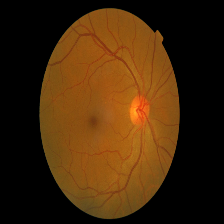

1/1 [==============================] - 1s 1s/step
[0. 0. 0.]
Predicted Label: 0


In [ ]:
predict_("/content/gdrive/MyDrive/train.zip/train/28780_right.jpeg")

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(H.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
hist_df

,loss,accuracy,val_loss,val_accuracy
0,0.753244,0.690374,0.503133,0.787375
1,0.514753,0.793103,0.507797,0.782392
2,0.482982,0.802443,0.500098,0.799003
3,0.455528,0.808908,0.450339,0.800664
4,0.375791,0.840517,0.508290,0.812292
5,0.356149,0.852730,0.479966,0.802326
6,0.361086,0.847701,0.431156,0.813953
7,0.334698,0.870690,0.383823,0.843854
8,0.331794,0.858477,0.388216,0.842193
9,0.315898,0.870690,0.445420,0.807309


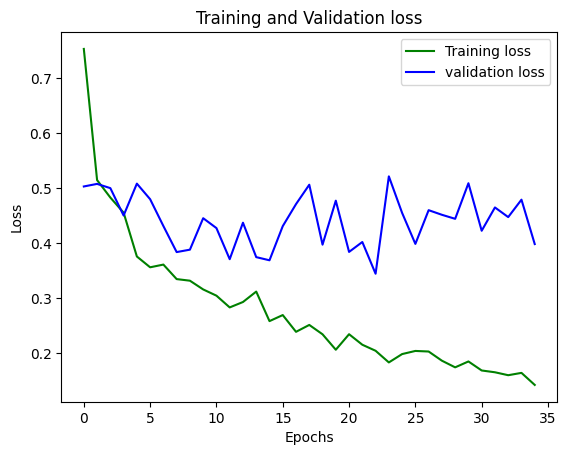

In [ ]:
import matplotlib.pyplot as plt
loss_train = hist_df['loss']
loss_val = hist_df['val_loss']
epochs = range(35)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

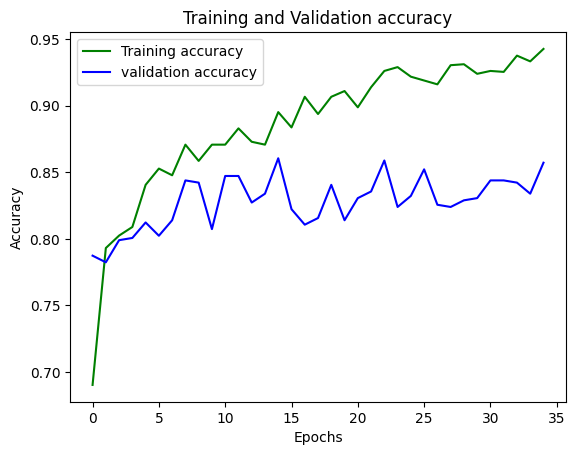

In [ ]:
loss_train = hist_df['accuracy']
loss_val = hist_df['val_accuracy']
epochs = range(35)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
true_value = []
predicted_value = []
plt.figure(figsize=(10,10))
import os
from os import listdir
# get the path or directory
testImages = []
folder_dir = "/content/gdrive/MyDrive/TEST_UP/Test_img_0"
for i in os.listdir(folder_dir):
    # check if the image ends with png or jpg or jpeg
    if (i.endswith(".png") or i.endswith(".jpg")\
        or i.endswith(".jpeg")):
        testImages.append(folder_dir+'/'+i)
        true_value.append(0)
folder_dir = "/content/gdrive/MyDrive/TEST_UP/Test_img_1"
for i in os.listdir(folder_dir):
    # check if the image ends with png or jpg or jpeg
    if (i.endswith(".png") or i.endswith(".jpg")\
        or i.endswith(".jpeg")):
        testImages.append(folder_dir+'/'+i)
        true_value.append(1)
folder_dir = "/content/gdrive/MyDrive/TEST_UP/Test_img_2"
for i in os.listdir(folder_dir):
    # check if the image ends with png or jpg or jpeg
    if (i.endswith(".png") or i.endswith(".jpg")\
        or i.endswith(".jpeg")):
        testImages.append(folder_dir+'/'+i)
        true_value.append(2)


def predict_(image_path):
  #Load the Model from Json File
  json_file = open('/content/gdrive/My Drive/model.json', 'r')
  model_json_c = json_file.read()
  json_file.close()
  model_c = model_from_json(model_json_c)
  #Load the weights
  model_c.load_weights("/content/gdrive/My Drive/best_model.h5")
  #Compile the model
  opt = SGD(lr=1e-4, momentum=0.9)
  model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
  #load the image you want to classify
  image = cv2.imread(image_path)
  image = cv2.resize(image, (224,224))
  #cv2_imshow(image)
  #predict the image
  preds = model_c.predict(np.expand_dims(image, axis=0))[0]
  prediction = max(preds)
  #print(preds)

  if prediction==preds[0]:
      #print("Predicted Label: 0")
      predicted_value.append(0)
  elif prediction==preds[1]:
      #print("Predicted Label: 1")
      predicted_value.append(1)
  else:
      #print("Predicted Label: 2")
      predicted_value.append(2)


for image in testImages:
  print(image)
  predict_(image)





/content/gdrive/MyDrive/TEST_UP/Test_img_0/16060_right.jpeg
1/1 [==============================] - 2s 2s/step
/content/gdrive/MyDrive/TEST_UP/Test_img_0/16065_right.jpeg
1/1 [==============================] - 1s 937ms/step
/content/gdrive/MyDrive/TEST_UP/Test_img_0/16076_right.jpeg
1/1 [==============================] - 2s 2s/step
/content/gdrive/MyDrive/TEST_UP/Test_img_0/16088_right.jpeg
1/1 [==============================] - 3s 3s/step
/content/gdrive/MyDrive/TEST_UP/Test_img_0/16095_left.jpeg
1/1 [==============================] - 3s 3s/step
/content/gdrive/MyDrive/TEST_UP/Test_img_0/16095_right.jpeg
1/1 [==============================] - 1s 1s/step
/content/gdrive/MyDrive/TEST_UP/Test_img_0/1610_left.jpeg
1/1 [==============================] - 1s 903ms/step
/content/gdrive/MyDrive/TEST_UP/Test_img_0/1610_right.jpeg
1/1 [==============================] - 1s 869ms/step
/content/gdrive/MyDrive/TEST_UP/Test_img_0/16110_right.jpeg
1/1 [==============================] - 1s 859ms/step
/c

<Figure size 1000x1000 with 0 Axes>

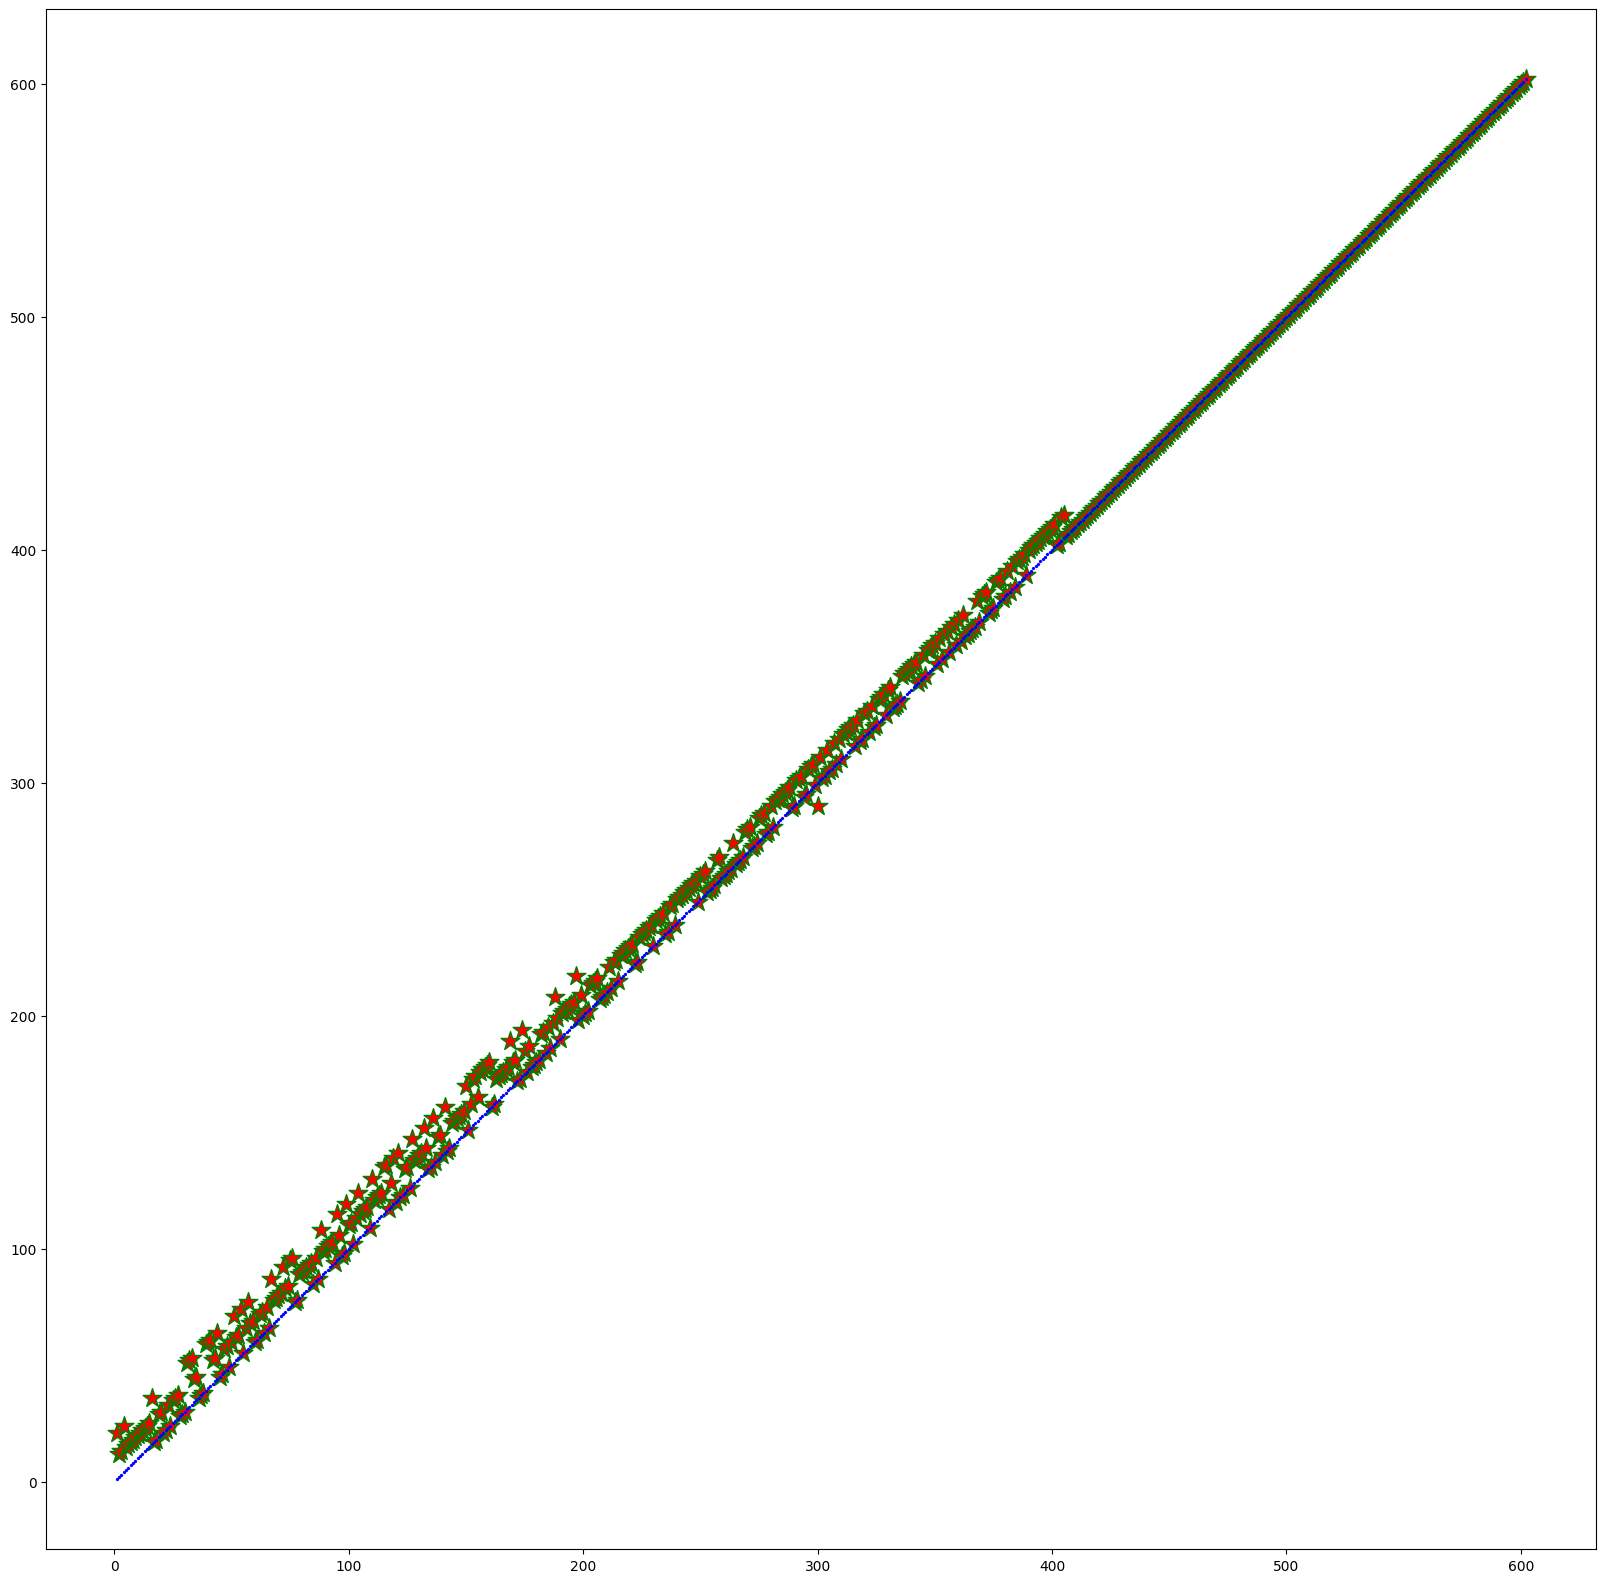

In [ ]:
li = []
for i in range(len(predicted_value)):
  li.append(i+1)
for i in range(len(predicted_value)):
  li[i] = li[i]+(predicted_value[i]-true_value[i])*10
Li = []
for i in range(i+1):
  Li.append(i+1)

plt.figure(figsize=(20,20))
plt.scatter(Li, li, c ="red",
            linewidths =1,
            marker ="*",
            edgecolor ="green",
            s = 200)
plt.scatter(Li, Li, c ="blue",
            linewidths =0.11,
            marker =".",
            edgecolor ="blue",
            s = 20)
plt.show()
